In [1]:
import pandas as pd
from google.cloud import bigquery
import matplotlib.pyplot as plt

In [2]:
london_weather_data = pd.read_csv("london_weather.csv")
london_weather_data['date'] = pd.to_datetime(london_weather_data['date'], unit='m')

In [3]:
london_weather_data = london_weather_data.dropna(subset=['date', 'mean_temp'], how='all')
london_weather_data['year'] = london_weather_data['date'].dt.year
london_weather_data['month'] = london_weather_data['date'].dt.month
london_weather_data.head()

,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth,year,month
0,2007-08-18 03:01:00,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0,9.0,2007,8
1,2007-08-18 03:02:00,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0,8.0,2007,8
2,2007-08-18 03:03:00,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0,4.0,2007,8
3,2007-08-18 03:04:00,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0,2.0,2007,8
4,2007-08-18 03:05:00,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0,1.0,2007,8


In [4]:
averaged_london_temp_data = london_weather_data.groupby(['year', 'month'])['mean_temp'].mean().reset_index()
averaged_london_temp_data

,year,month,mean_temp
0,2007,8,10.178796
1,2007,9,10.719003
2,2007,10,10.814031
3,2007,11,11.393610
4,2007,12,11.451098
5,2008,1,11.433656
6,2008,2,12.320896
7,2008,3,11.521241
8,2008,4,11.822450
9,2008,5,12.309505


In [5]:
unique_years = averaged_london_temp_data['year'].unique()
unique_years

array([2007, 2008], dtype=int32)

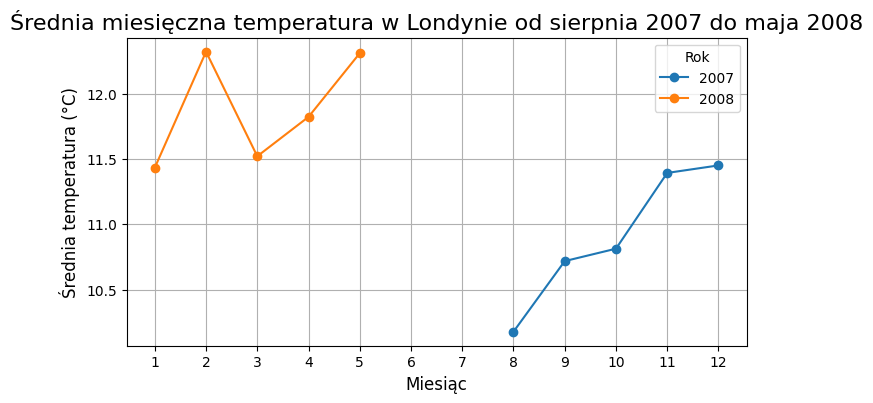

In [6]:
fig, ax = plt.subplots(figsize=(8, 4))

for year in unique_years:
    df_year = averaged_london_temp_data[averaged_london_temp_data['year'] == year]
    
    ax.plot(df_year['month'], df_year['mean_temp'], marker='o', label=str(year))

ax.set_title('Średnia miesięczna temperatura w Londynie od sierpnia 2007 do maja 2008', fontsize=16)
ax.set_xlabel('Miesiąc', fontsize=12)
ax.set_ylabel('Średnia temperatura (°C)', fontsize=12)
ax.legend(title='Rok')
ax.grid(True)
ax.set_xticks(range(1, 13))

In [7]:
PROJECT_ID = "thinking-park-468115-u1"
DATASET_ID = "first_etl_project"
TABLE_ID = "first_etl_project"
TEMP_TABLE_ID = "weahter_data_temp"

client = bigquery.Client(project=PROJECT_ID)

full_table_id = f"{PROJECT_ID}.{DATASET_ID}.{TABLE_ID}"
full_temp_table_id = f"{PROJECT_ID}.{DATASET_ID}.{TEMP_TABLE_ID}"

job_config = bigquery.LoadJobConfig(
    schema=[
        bigquery.SchemaField("year", "INT64", mode="REQUIRED"),
        bigquery.SchemaField("month", "INT64", mode="REQUIRED"),
        bigquery.SchemaField("mean_temp", "FLOAT", mode="REQUIRED"),
    ],
    write_disposition=bigquery.WriteDisposition.WRITE_TRUNCATE,
)

try:
    job = client.load_table_from_dataframe(
        averaged_london_temp_data, full_temp_table_id, job_config=job_config
    )
    job.result()
    print("Success while trying to load data to BigQuery")
except Exception as e:
    print(f"Error while trying to load data to BigQuery: {e}")
    exit()

merge_query = f"""
MERGE INTO `{full_table_id}` AS T
USING `{full_temp_table_id}` AS S
ON T.year = S.year AND T.month = S.month
WHEN MATCHED THEN
    UPDATE SET
        T.mean_temp = S.mean_temp
WHEN NOT MATCHED THEN
    INSERT (year, month, mean_temp) VALUES (S.year, S.month, S.mean_temp)
"""

try:
    query_job = client.query(merge_query)
    query_job.result()
    print("Merge successful. Table updated.")
except Exception as e:
    print(f"Error while attempting to merge: {e}")

c:\Users\mper\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\auth\_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
c:\Users\mper\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\cloud\bigquery\_pandas_helpers.py:484: FutureWarning: Loading pandas DataFrame into BigQuery will require pandas-gbq package version 0.26.1 or greater in the future. Tried to import pandas-gbq and got: No module named 'pandas_gbq'
  warnings.warn(


Success while trying to load data to BigQuery
Merge successful. Table updated.
